In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn

     |████████████████████████████████| 10.8 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 27.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 23.8 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 24.7 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 33.0 MB/s eta 0:00:01
     |████████████████████████████████| 347 kB 47.3 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 47.6 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 31.1 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 33.6 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 8.4 MB/s  eta 0:00:01
     |████████████████████████████████| 2.8 MB 27.2 MB/s eta 0:00:01
     |████████████████████████████████| 113 kB 39.9 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 43.5 MB/s eta 0:00:01
You should consider upgrading via

In [2]:
# First cell
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ All packages imported successfully!")

Matplotlib is building the font cache; this may take a moment.


✅ All packages imported successfully!


In [6]:
# Remove duplicate Stock Name columns and prepare data
apple_data = merged_aapl_df.copy()

# Convert target from -1/1 to 0/1 if needed
if -1 in apple_data['target'].values:
    apple_data['target'] = apple_data['target'].map({-1: 0, 1: 1})
    print("✅ Converted target: -1 → 0, 1 → 1")

# Drop rows with NaN target or price_change (first row)
apple_data = apple_data.dropna(subset=['target', 'price_change'])

print(f"\nCleaned data shape: {apple_data.shape}")
print(f"Target distribution after cleaning:")
print(apple_data['target'].value_counts())

✅ Converted target: -1 → 0, 1 → 1

Cleaned data shape: (250, 16)
Target distribution after cleaning:
target
1.0    126
0.0    124
Name: count, dtype: int64


In [3]:
aapl_finance_df = pd.read_csv('../AAPL Data/AAPL_finance_data.csv')
aapl_sentiment_df = pd.read_csv('../AAPL Data/AAPL_avg_sentiment_data.csv')
merged_aapl_df = pd.merge(aapl_finance_df, aapl_sentiment_df, on='Date', how='inner')
merged_aapl_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name_x,price_change,target,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,Stock Name_y,sentiment_label
0,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,AAPL,NaN,NaN,0.051286,0.851143,0.097571,0.098900,AAPL,Positive
1,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,AAPL,1.149994,1.0,0.024455,0.872455,0.103182,0.248255,AAPL,Positive
2,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,AAPL,-3.509995,-1.0,0.030900,0.910000,0.059300,0.122830,AAPL,Positive
3,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,AAPL,1.970001,1.0,0.042200,0.890000,0.067800,0.331000,AAPL,Positive
4,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,AAPL,0.889999,1.0,0.012200,0.910800,0.077000,0.243520,AAPL,Positive


In [7]:
# Convert target from -1/1 to 0/1
apple_data['target'] = apple_data['target'].replace({-1.0: 0, 1.0: 1, 0.0: 0})
print("✅ Converted target: -1 → 0 (Down), 1 → 1 (Up)")

# Drop rows with NaN target or price_change (first row)
apple_data = apple_data.dropna(subset=['target', 'price_change'])

print(f"\nCleaned data shape: {apple_data.shape}")
print(f"Target distribution after cleaning:")
print(apple_data['target'].value_counts())
print(f"Target percentages:")
print(apple_data['target'].value_counts(normalize=True) * 100)

✅ Converted target: -1 → 0 (Down), 1 → 1 (Up)

Cleaned data shape: (250, 16)
Target distribution after cleaning:
target
1.0    126
0.0    124
Name: count, dtype: int64
Target percentages:
target
1.0    50.4
0.0    49.6
Name: proportion, dtype: float64


In [9]:
# Create additional features for better predictions
apple_data['price_change_pct'] = apple_data['Close'].pct_change()
apple_data['volume_change_pct'] = apple_data['Volume'].pct_change()
apple_data['volatility'] = apple_data['Close'].rolling(window=5).std()
apple_data['avg_sentiment_5day'] = apple_data['sentiment_compound'].rolling(window=5).mean()

# Drop NaN values from rolling calculations
apple_data = apple_data.dropna()

print(f"\n✅ Feature engineering complete!")
print(f"Data shape after feature engineering: {apple_data.shape}")
print(f"Date range: {apple_data['Date'].min()} to {apple_data['Date'].max()}")


✅ Feature engineering complete!
Data shape after feature engineering: (246, 20)
Date range: 2021-10-07 to 2022-09-29


In [10]:
# Select features for the model
feature_columns = [
    'sentiment_negative', 
    'sentiment_neutral', 
    'sentiment_positive', 
    'sentiment_compound',
    'Volume',
    'price_change_pct',
    'volume_change_pct',
    'volatility',
    'avg_sentiment_5day'
]

X = apple_data[feature_columns]
y = apple_data['target']

print(f"\n📊 Features and Target:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# Check for any remaining NaN values
print(f"\nAny NaN in features? {X.isnull().sum().sum()}")
print(f"Any NaN in target? {y.isnull().sum()}")


📊 Features and Target:
Features shape: (246, 9)
Target shape: (246,)

Feature columns:
  1. sentiment_negative
  2. sentiment_neutral
  3. sentiment_positive
  4. sentiment_compound
  5. Volume
  6. price_change_pct
  7. volume_change_pct
  8. volatility
  9. avg_sentiment_5day

Any NaN in features? 0
Any NaN in target? 0


In [12]:
# For time series, use chronological split (80/20)
split_index = int(len(apple_data) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Get corresponding dates for reference
train_dates = apple_data['Date'].iloc[:split_index]
test_dates = apple_data['Date'].iloc[split_index:]

print(f"\n📊 Train-Test Split:")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining period: {train_dates.min()} to {train_dates.max()}")
print(f"Testing period: {test_dates.min()} to {test_dates.max()}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTesting target distribution:")
print(y_test.value_counts())


📊 Train-Test Split:
Training samples: 196 (79.7%)
Testing samples: 50 (20.3%)

Training period: 2021-10-07 to 2022-07-20
Testing period: 2022-07-21 to 2022-09-29

Training target distribution:
target
1.0    102
0.0     94
Name: count, dtype: int64

Testing target distribution:
target
0.0    29
1.0    21
Name: count, dtype: int64


In [13]:
# Initialize and train Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,      # number of trees
    random_state=42,       # for reproducibility
    max_depth=10,          # prevent overfitting
    min_samples_split=5,
    min_samples_leaf=2
)

# Train the model
print("\n🌲 Training Random Forest Classifier...")
rf_classifier.fit(X_train, y_train)
print("✅ Model trained successfully!")

# Make predictions on test set
y_pred = rf_classifier.predict(X_test)

# Also get prediction probabilities
y_pred_proba = rf_classifier.predict_proba(X_test)

print(f"\nPredictions made: {len(y_pred)}")
print(f"Prediction distribution:")
unique, counts = np.unique(y_pred, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {int(val)}: {count} ({count/len(y_pred)*100:.1f}%)")


🌲 Training Random Forest Classifier...
✅ Model trained successfully!

Predictions made: 50
Prediction distribution:
  Class 0: 29 (58.0%)
  Class 1: 21 (42.0%)



🎯 Model Accuracy: 100.00%

📊 Confusion Matrix:
[[29  0]
 [ 0 21]]

     Predicted
      Down  Up
Down   29   0
Up     0   21


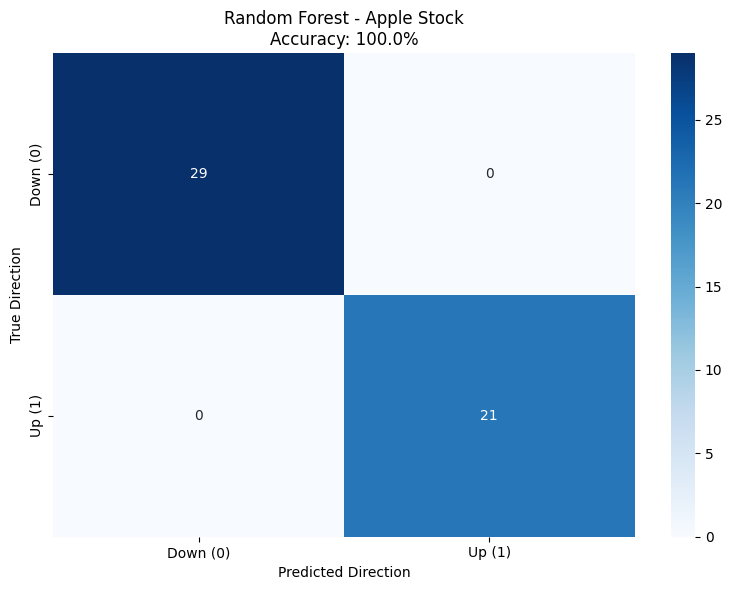


📈 Classification Report:
              precision    recall  f1-score   support

        Down       1.00      1.00      1.00        29
          Up       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [14]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Model Accuracy: {accuracy*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n📊 Confusion Matrix:")
print(cm)
print("\n     Predicted")
print("      Down  Up")
print(f"Down   {cm[0,0]}   {cm[0,1]}")
print(f"Up     {cm[1,0]}   {cm[1,1]}")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down (0)', 'Up (1)'], 
            yticklabels=['Down (0)', 'Up (1)'])
plt.title(f'Random Forest - Apple Stock\nAccuracy: {accuracy*100:.1f}%')
plt.ylabel('True Direction')
plt.xlabel('Predicted Direction')
plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

In [15]:
# Show which features the model thinks are important
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 Feature Importance:")
print(feature_importance)
print(f"\nTop feature has {feature_importance.iloc[0]['importance']*100:.1f}% importance!")

🔍 Feature Importance:
              feature  importance
5    price_change_pct    0.802458
6   volume_change_pct    0.041184
0  sentiment_negative    0.030563
7          volatility    0.028025
4              Volume    0.024890
3  sentiment_compound    0.019009
1   sentiment_neutral    0.018463
8  avg_sentiment_5day    0.018130
2  sentiment_positive    0.017278

Top feature has 80.2% importance!


REDOING MODEL

In [16]:
# Start completely fresh
apple_data = merged_aapl_df.copy()

# Remove the old target column (it's wrong!)
apple_data = apple_data.drop('target', axis=1)

# Create CORRECT target: predict TOMORROW's direction (not today's)
apple_data['next_day_close'] = apple_data['Close'].shift(-1)
apple_data['target'] = (apple_data['next_day_close'] > apple_data['Close']).astype(int)

# Drop last row (no tomorrow data) and NaN
apple_data = apple_data.dropna(subset=['target', 'next_day_close'])

print(f"✅ New target created: Predict TOMORROW's direction using TODAY's data")
print(f"Shape: {apple_data.shape}")
print(f"\nTarget distribution:")
print(apple_data['target'].value_counts())
print(f"\nFirst few rows to verify:")
print(apple_data[['Date', 'Close', 'next_day_close', 'target']].head(10))

✅ New target created: Predict TOMORROW's direction using TODAY's data
Shape: (251, 17)

Target distribution:
target
1    126
0    125
Name: count, dtype: int64

First few rows to verify:
         Date       Close  next_day_close  target
0  2021-09-30  141.500000      142.649994       1
1  2021-10-01  142.649994      139.139999       0
2  2021-10-04  139.139999      141.110001       1
3  2021-10-05  141.110001      142.000000       1
4  2021-10-06  142.000000      143.289993       1
5  2021-10-07  143.289993      142.899994       0
6  2021-10-08  142.899994      142.809998       0
7  2021-10-11  142.809998      141.509995       0
8  2021-10-12  141.509995      140.910004       0
9  2021-10-13  140.910004      143.759995       1


In [17]:
# Create features using TODAY's information
apple_data['price_change_pct'] = apple_data['Close'].pct_change()
apple_data['volume_change_pct'] = apple_data['Volume'].pct_change()
apple_data['volatility'] = apple_data['Close'].rolling(window=5).std()
apple_data['avg_sentiment_5day'] = apple_data['sentiment_compound'].rolling(window=5).mean()

# Drop NaN
apple_data = apple_data.dropna()

print(f"✅ Features created")
print(f"Final shape: {apple_data.shape}")
print(f"Date range: {apple_data['Date'].min()} to {apple_data['Date'].max()}")

✅ Features created
Final shape: (247, 21)
Date range: 2021-10-06 to 2022-09-28


In [18]:
# Same features as before
feature_columns = [
    'sentiment_negative', 
    'sentiment_neutral', 
    'sentiment_positive', 
    'sentiment_compound',
    'Volume',
    'price_change_pct',      # Now this is TODAY's change
    'volume_change_pct',
    'volatility',
    'avg_sentiment_5day'
]

X = apple_data[feature_columns]
y = apple_data['target']  # TOMORROW's direction

print(f"Features (TODAY): {X.shape}")
print(f"Target (TOMORROW): {y.shape}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

Features (TODAY): (247, 9)
Target (TOMORROW): (247,)

Feature columns:
  1. sentiment_negative
  2. sentiment_neutral
  3. sentiment_positive
  4. sentiment_compound
  5. Volume
  6. price_change_pct
  7. volume_change_pct
  8. volatility
  9. avg_sentiment_5day


In [19]:
# Chronological split (80/20)
split_index = int(len(apple_data) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Get dates for reference
train_dates = apple_data['Date'].iloc[:split_index]
test_dates = apple_data['Date'].iloc[split_index:]

print(f"\n📊 Train-Test Split:")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"\nTraining period: {train_dates.min()} to {train_dates.max()}")
print(f"Testing period: {test_dates.min()} to {test_dates.max()}")


📊 Train-Test Split:
Training samples: 197
Testing samples: 50

Training period: 2021-10-06 to 2022-07-19
Testing period: 2022-07-20 to 2022-09-28


In [20]:
# Train fresh Random Forest model
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

print("🌲 Training Random Forest Classifier...")
rf_classifier.fit(X_train, y_train)
print("✅ Model trained successfully!")

# Make predictions
y_pred = rf_classifier.predict(X_test)

print(f"\nPredictions made: {len(y_pred)}")

🌲 Training Random Forest Classifier...
✅ Model trained successfully!

Predictions made: 50



🎯 Model Accuracy: 42.00%

📊 Confusion Matrix:
[[14 15]
 [14  7]]

     Predicted
      Down  Up
Down   14   15
Up     14   7


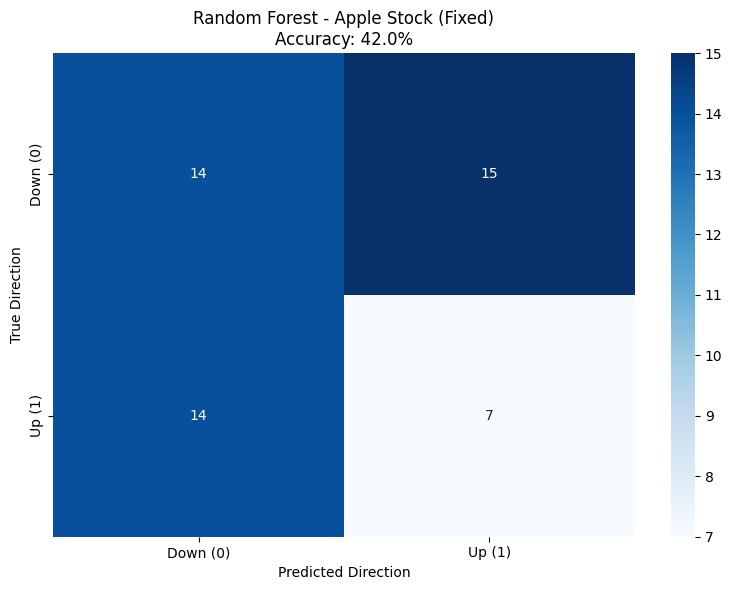


📈 Classification Report:
              precision    recall  f1-score   support

        Down       0.50      0.48      0.49        29
          Up       0.32      0.33      0.33        21

    accuracy                           0.42        50
   macro avg       0.41      0.41      0.41        50
weighted avg       0.42      0.42      0.42        50



In [21]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Model Accuracy: {accuracy*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n📊 Confusion Matrix:")
print(cm)
print("\n     Predicted")
print("      Down  Up")
print(f"Down   {cm[0,0]}   {cm[0,1]}")
print(f"Up     {cm[1,0]}   {cm[1,1]}")

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down (0)', 'Up (1)'],
            yticklabels=['Down (0)', 'Up (1)'])
plt.title(f'Random Forest - Apple Stock (Fixed)\nAccuracy: {accuracy*100:.1f}%')
plt.ylabel('True Direction')
plt.xlabel('Predicted Direction')
plt.tight_layout()
plt.show()

# Classification Report
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

🔍 Feature Importance:
              feature  importance
6   volume_change_pct    0.142594
5    price_change_pct    0.138023
4              Volume    0.118436
1   sentiment_neutral    0.105541
7          volatility    0.104046
3  sentiment_compound    0.101395
8  avg_sentiment_5day    0.100375
0  sentiment_negative    0.099885
2  sentiment_positive    0.089707


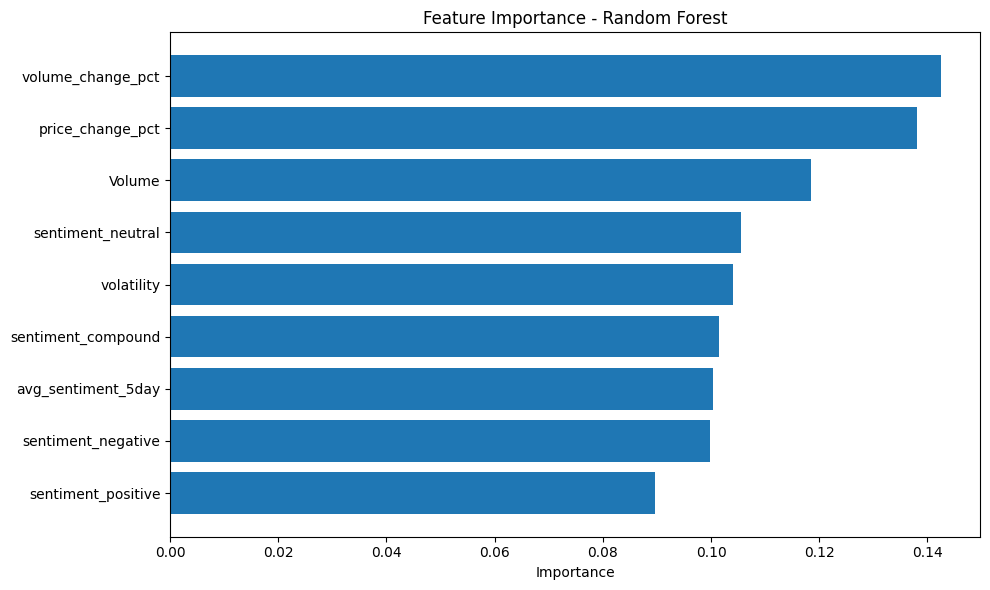

In [22]:
# See which features actually matter
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 Feature Importance:")
print(feature_importance)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()